## Can mlp learn to classifier clean modulated signals just as well as convnet?

In [4]:
import pickle
import matplotlib.pyplot as plt

In [5]:
with open('./Data/Unimpaired_diff_BW_mod22.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')

print(data.keys())

dict_keys(['32apsk', '2fsk', 'cpfsk', '64apsk', 'ook', 'qam64', 'oqpsk', 'qpsk', '8psk', '16psk', 'gmsk', 'qam256', '4fsk', 'pam4', '16apsk', 'qam32', 'bpsk', '128apsk', '256apsk', '32psk', 'qam16', 'gfsk'])


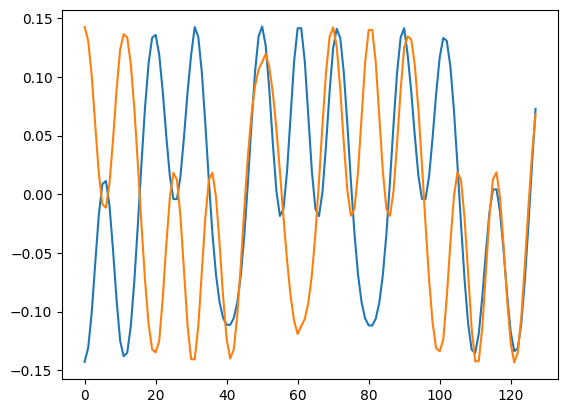

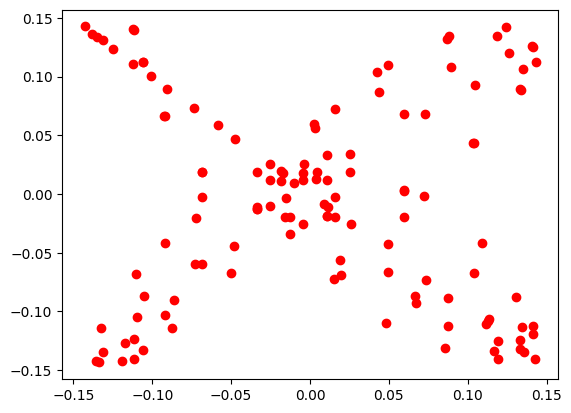

In [6]:
oqpsk = data['oqpsk']
plt.figure(1)
plt.plot(oqpsk[0].T)
plt.figure(2)
plt.scatter(oqpsk[0][0], oqpsk[0][1], c='r')

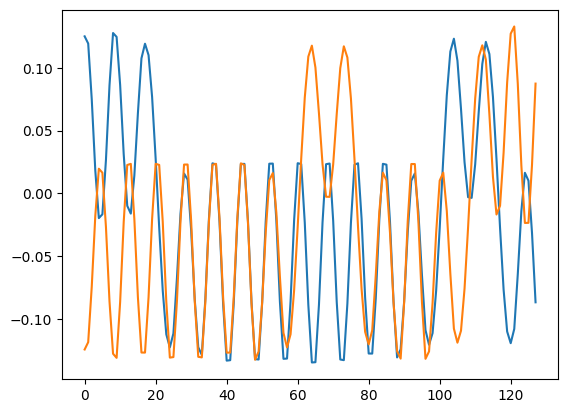

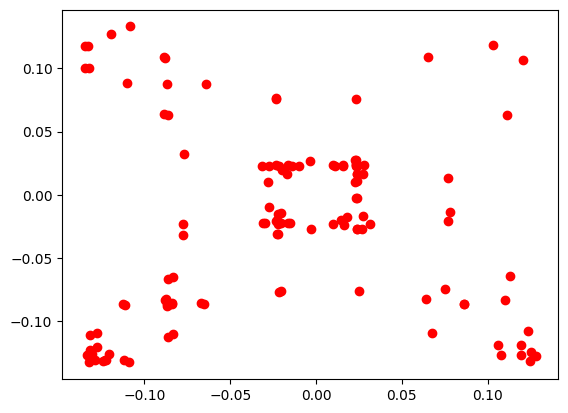

In [7]:
gmsk = data['gmsk']
plt.figure(1)
plt.plot(gmsk[0].T)
plt.figure(2)
plt.scatter(gmsk[0][0], gmsk[0][1], c='r')

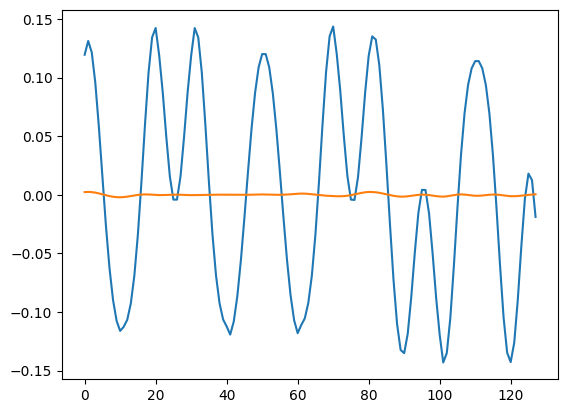

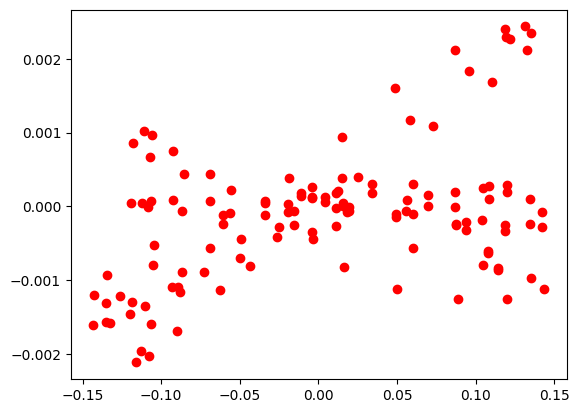

In [8]:
bpsk = data['bpsk']
plt.figure(1)
plt.plot(bpsk[0].T)
plt.figure(2)
plt.scatter(bpsk[0][0], bpsk[0][1], c='r')

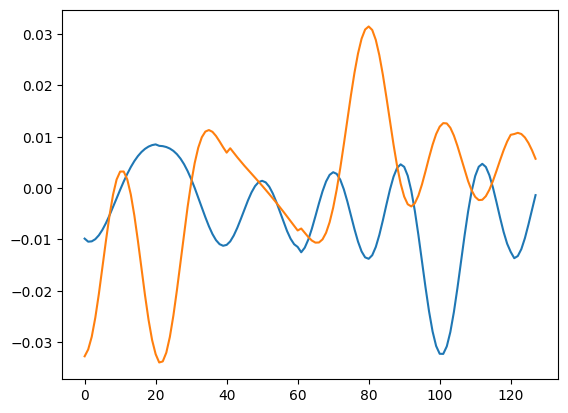

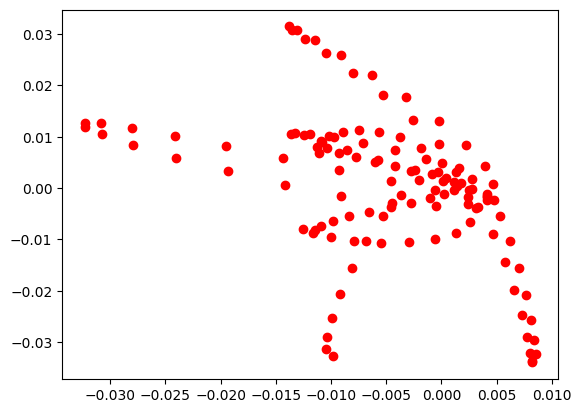

In [9]:
qam16 = data['qam16']
plt.figure(1)
plt.plot(qam16[0].T)
plt.figure(2)
plt.scatter(qam16[0][0], qam16[0][1], c='r')

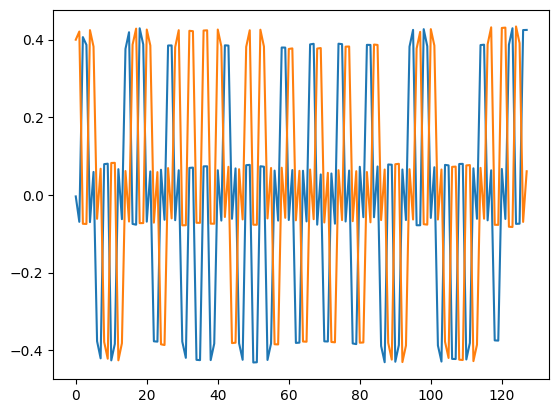

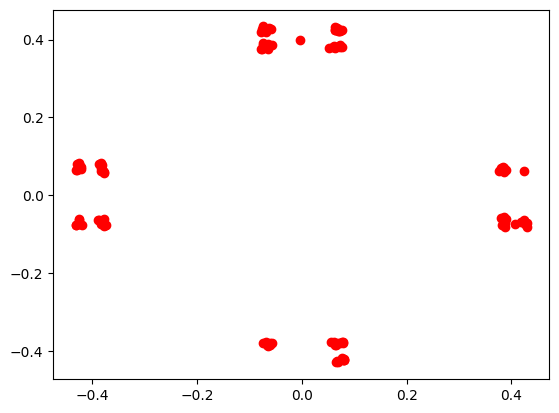

In [10]:
fsk4 = data['4fsk']
plt.figure(1)
plt.plot(fsk4[0].T)
plt.figure(2)
plt.scatter(fsk4[0][0], fsk4[0][1], c='r')

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.transforms import Compose, Lambda

import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
class IQ2LabelsDataset(Dataset):
    def __init__(self, data, labels, data_transform=None):
        self.data = data
        self.labels = labels
        self.data_transform = data_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        labels = self.labels[idx]
        if self.data_transform:
            data = self.data_transform(data)
        elif isinstance(data, np.ndarray):
            data = torch.from_numpy(data).float()
        return data, labels

In [14]:
labels = data.keys()
X = np.concatenate([data[label] for label in labels])
y = np.concatenate([np.ones(data[label].shape[0]) *
                   i for i, label in enumerate(labels)])
X.shape, y.shape

((219912, 2, 128), (219912,))

In [15]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
train_idx, test_idx = next(sss.split(X, y))

In [16]:
MLP_txfm = Compose([
    Lambda(lambda x: torch.tensor(x).float()),
    Lambda(lambda x: x.view(-1))
])

dataset = IQ2LabelsDataset(X[train_idx], y[train_idx], data_transform=MLP_txfm)

train_dataset, val_dataset = random_split(
    dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [17]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [18]:
class ConvNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, 16, 5, padding='same')
        self.conv2 = nn.Conv1d(16, 32, 5, padding='same')
        self.maxpool = nn.MaxPool1d(2)  # 2x downsampling
        self.fc1 = nn.Linear(1024, num_classes)  # 128 / 4 * 32 = 1024

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [19]:
def train_one_epoch(model, optimizer, criterion, train_loader):
    model.train()
    avg_loss = 0.
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, labels.long())
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
    return avg_loss / len(train_loader)


def validate(model, criterion, val_loader):
    model.eval()
    avg_loss = 0.
    correct = 0
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            output = model(data)
            avg_loss += criterion(output, labels.long()).item()
            pred = F.softmax(output, dim=-1).argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()
    return avg_loss / len(val_loader), correct / len(val_loader.dataset)

In [43]:
class Tracker:
    def __init__(self, metric, mode='auto'):
        self.metric = metric
        self.mode = mode
        self.mode_dict = {
            'auto': np.less if 'loss' in metric else np.greater,
            'min': np.less,
            'max': np.greater
        }
        self.operator = self.mode_dict[mode]

        self._best = np.inf if 'loss' in metric else -np.inf

    @property
    def best(self):
        return self._best

    @best.setter
    def best(self, value):
        self._best = value

In [21]:
NUM_EPOCHS = 50

model = MLP(in_features=2*128, hidden_features=256,
            out_features=len(labels)).to(device)
optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-3, weight_decay=5e-4)  # L2 regularization
criterion = nn.CrossEntropyLoss()
tracker = Tracker('val_loss')

print(f'Model has {sum(p.numel() for p in model.parameters())} parameters')


history = {
    'train_loss': [],
    'val_loss': [],
    'val_acc': []
}
for epoch in range(NUM_EPOCHS):
    train_loss = train_one_epoch(model, optimizer, criterion, train_loader)
    val_loss, val_acc = validate(model, criterion, val_loader)
    print(
        f'Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val Acc: {val_acc}')

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if tracker.operator(val_loss, tracker.best):
        tracker.best = val_loss
        torch.save(model.state_dict(), './Models/best_mlp.pth')
        print('Model saved with val loss:',
              val_loss, 'at ./Models/best_mlp.pth')

Model has 137238 parameters
Epoch 0, Train Loss: 1.5615006692225544, Val Loss: 1.195315444209494, Val Acc: 0.6007210601533065
Model saved with val loss: 1.195315444209494 at ./Models/best_mlp.pth
Epoch 1, Train Loss: 1.0785908834458513, Val Loss: 0.9893535620698305, Val Acc: 0.6645771079641418
Model saved with val loss: 0.9893535620698305 at ./Models/best_mlp.pth
Epoch 2, Train Loss: 0.9242074874104633, Val Loss: 0.8975220439899501, Val Acc: 0.6850396258282447
Model saved with val loss: 0.8975220439899501 at ./Models/best_mlp.pth
Epoch 3, Train Loss: 0.8525053265033433, Val Loss: 0.860395733038832, Val Acc: 0.700630115629466
Model saved with val loss: 0.860395733038832 at ./Models/best_mlp.pth
Epoch 4, Train Loss: 0.8084841359974843, Val Loss: 0.8214058227380612, Val Acc: 0.7132973885929583
Model saved with val loss: 0.8214058227380612 at ./Models/best_mlp.pth
Epoch 5, Train Loss: 0.780529756055432, Val Loss: 0.8097516180694041, Val Acc: 0.7185916590879563
Model saved with val loss: 0.

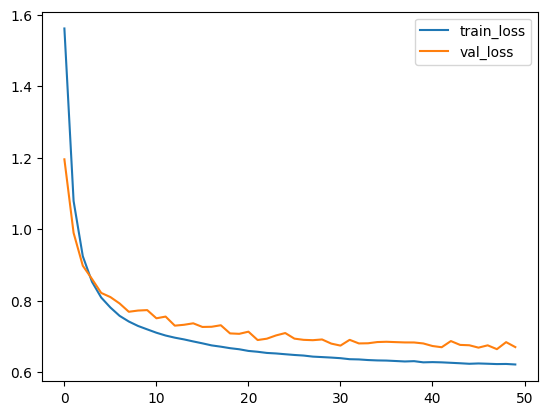

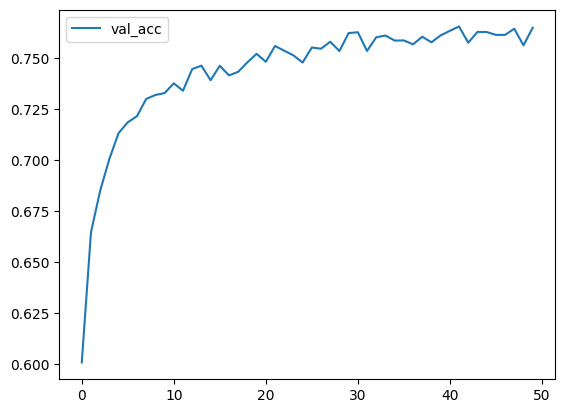

In [22]:
plt.figure(1)
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()

plt.figure(2)
plt.plot(history['val_acc'], label='val_acc')
plt.legend()

In [25]:
dataset = IQ2LabelsDataset(X[train_idx], y[train_idx])

train_dataset, val_dataset = random_split(
    dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [26]:
model = ConvNet(in_channels=2, num_classes=len(labels)).to(device)
optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-3, weight_decay=5e-4)  # L2 regularization
criterion = nn.CrossEntropyLoss()
tracker = Tracker('val_loss')

print(f'Model has {sum(p.numel() for p in model.parameters())} parameters')


history = {
    'train_loss': [],
    'val_loss': [],
    'val_acc': []
}
for epoch in range(NUM_EPOCHS):
    train_loss = train_one_epoch(model, optimizer, criterion, train_loader)
    val_loss, val_acc = validate(model, criterion, val_loader)
    print(
        f'Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val Acc: {val_acc}')

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if tracker.operator(val_loss, tracker.best):
        tracker.best = val_loss
        torch.save(model.state_dict(), './Models/best_convnet.pth')
        print('Model saved with val loss:',
              val_loss, 'at ./Models/best_convnet.pth')

Model has 25318 parameters
Epoch 0, Train Loss: 1.521998929602662, Val Loss: 1.150745428858764, Val Acc: 0.6234247109263349
Model saved with val loss: 1.150745428858764 at ./Models/best_convnet.pth
Epoch 1, Train Loss: 1.0167803649593867, Val Loss: 0.92795646453696, Val Acc: 0.6903014161361569
Model saved with val loss: 0.92795646453696 at ./Models/best_convnet.pth
Epoch 2, Train Loss: 0.8587784675165535, Val Loss: 0.8477592653636497, Val Acc: 0.712063141483695
Model saved with val loss: 0.8477592653636497 at ./Models/best_convnet.pth
Epoch 3, Train Loss: 0.7651467124543645, Val Loss: 0.7424217336274381, Val Acc: 0.7476939067169027
Model saved with val loss: 0.7424217336274381 at ./Models/best_convnet.pth
Epoch 4, Train Loss: 0.7073597737715503, Val Loss: 0.7072610431742445, Val Acc: 0.7556515525529427
Model saved with val loss: 0.7072610431742445 at ./Models/best_convnet.pth
Epoch 5, Train Loss: 0.6669203581810617, Val Loss: 0.7130708966175963, Val Acc: 0.7436663635182539
Epoch 6, Tra

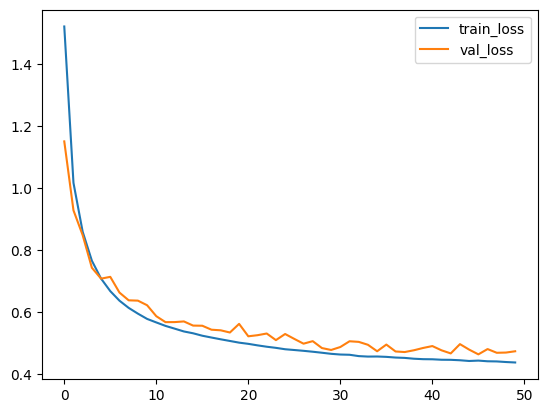

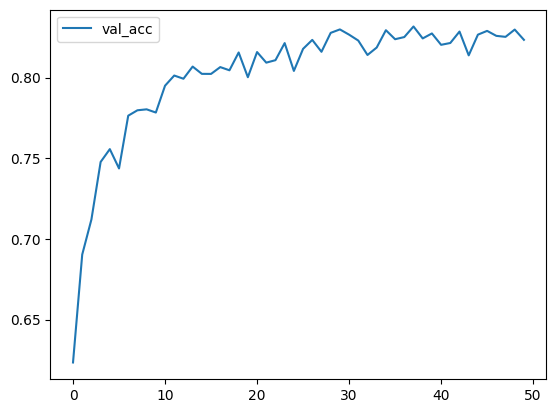

In [27]:
plt.figure(1)
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()

plt.figure(2)
plt.plot(history['val_acc'], label='val_acc')
plt.legend()

## Testing

In [30]:
results = {
    "mlp": {
        'preds': [],
        'labels': []
    },
    "convnet": {
        'preds': [],
        'labels': []
    }
}
test_dataset = IQ2LabelsDataset(
    X[test_idx], y[test_idx], data_transform=MLP_txfm)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


model = MLP(in_features=2*128, hidden_features=256,
            out_features=22)
model.load_state_dict(torch.load('./Models/best_mlp.pth', weights_only=True))

model = model.to(device)

model.eval()
with torch.no_grad():
    for data, labels in test_dataloader:
        data, labels = data.to(device), labels.to(device)
        output = model(data)
        pred = F.softmax(output, dim=-1).argmax(dim=1, keepdim=True)
        results['mlp']['preds'].extend(pred.cpu().numpy())
        results['mlp']['labels'].extend(labels.cpu().numpy())

test_dataset = IQ2LabelsDataset(X[test_idx], y[test_idx])
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = ConvNet(in_channels=2, num_classes=22).to(device)
model.load_state_dict(
    torch.load('./Models/best_convnet.pth', weights_only=True))

model.eval()
with torch.no_grad():
    for data, labels in test_dataloader:
        data, labels = data.to(device), labels.to(device)
        output = model(data)
        pred = F.softmax(output, dim=-1).argmax(dim=1, keepdim=True)
        results['convnet']['preds'].extend(pred.cpu().numpy())
        results['convnet']['labels'].extend(labels.cpu().numpy())

Performance of mlp
              precision    recall  f1-score   support

       oqpsk       0.62      0.68      0.65      2999
        gmsk       0.49      0.73      0.58      2999
      64apsk       0.49      0.27      0.35      2999
        2fsk       0.67      0.50      0.57      2999
         ook       0.99      1.00      0.99      2999
     128apsk       0.74      0.71      0.73      2999
        4fsk       0.95      0.96      0.95      2999
        8psk       0.77      0.85      0.81      2999
       16psk       0.73      0.63      0.67      2999
        bpsk       0.84      0.84      0.84      2999
       qam16       0.58      0.68      0.62      2998
       cpfsk       0.91      0.96      0.93      2999
      qam256       0.79      0.80      0.79      2999
     256apsk       0.99      0.99      0.99      2998
      16apsk       0.78      0.75      0.76      2998
        pam4       0.80      0.89      0.84      2999
       32psk       0.98      0.98      0.98      2999
        

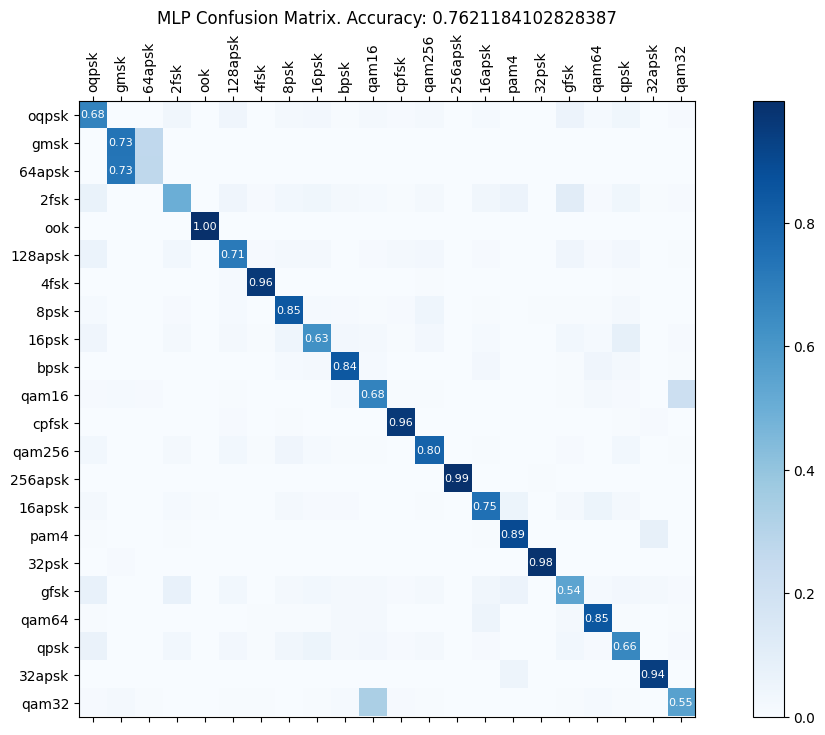

Performance of convnet
              precision    recall  f1-score   support

       oqpsk       0.82      0.75      0.78      2999
        gmsk       0.49      0.50      0.49      2999
      64apsk       0.49      0.49      0.49      2999
        2fsk       0.80      0.67      0.73      2999
         ook       1.00      1.00      1.00      2999
     128apsk       0.88      0.82      0.85      2999
        4fsk       0.99      0.99      0.99      2999
        8psk       0.94      0.88      0.91      2999
       16psk       0.73      0.92      0.82      2999
        bpsk       0.95      0.83      0.89      2999
       qam16       0.63      0.57      0.59      2998
       cpfsk       0.99      0.97      0.98      2999
      qam256       0.85      0.99      0.92      2999
     256apsk       1.00      1.00      1.00      2998
      16apsk       0.93      0.88      0.91      2998
        pam4       0.94      0.95      0.94      2999
       32psk       0.98      0.99      0.98      2999
    

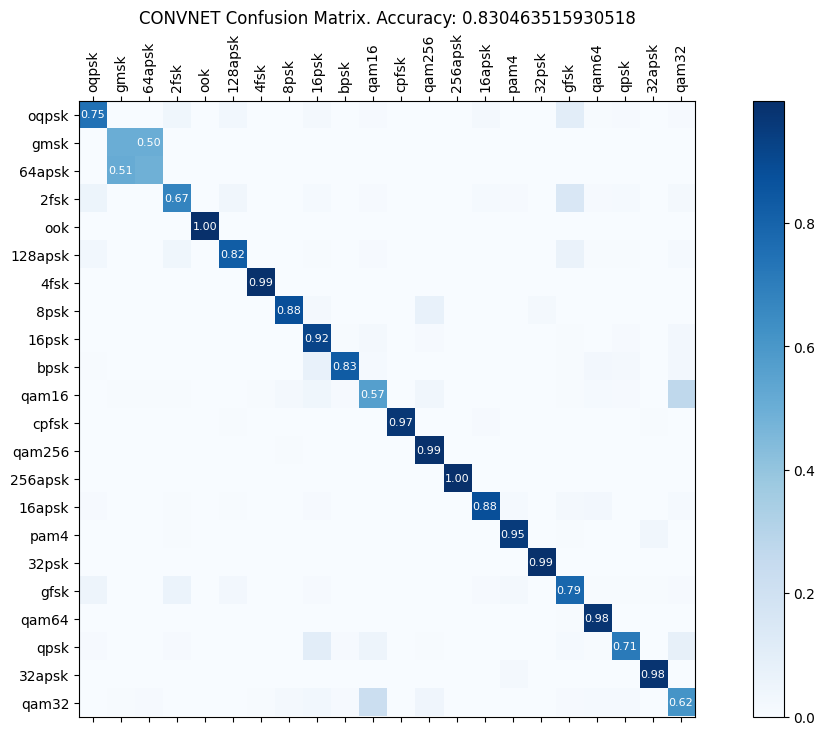

In [36]:
# visualize the results
# compute the accuracy, precision, recall, f1-score
# and the confusion matrix for each model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

plt.rcParams['figure.figsize'] = [15, 8]

labels = ['oqpsk', 'gmsk', '64apsk', '2fsk', 'ook', '128apsk', '4fsk', '8psk', '16psk', 'bpsk', 'qam16',
          'cpfsk', 'qam256', '256apsk', '16apsk', 'pam4', '32psk', 'gfsk', 'qam64', 'qpsk', '32apsk', 'qam32']
# reordered_label_names = ['bpsk', 'qpsk', '8psk', '16psk', '32psk', '16apsk', '32apsk', '64apsk', '128apsk', '256apsk',
#                     'qam16', 'qam32', 'qam64', 'qam256', 'ook', 'pam4', '2fsk', '4fsk', '8psk', 'gfsk', 'cpfsk', 'gmsk', 'oqpsk']  # place modulation of similar types together # noqa
# reordered_labels = [labels.index(label) for label in reordered_label_names]
for model_name, result in results.items():
    print(f'Performance of {model_name}')
    print(classification_report(
        result['labels'], result['preds'], target_names=labels))
    acc = accuracy_score(result['labels'], result['preds'])
    print('Accuracy:', acc)
    conf_mat = confusion_matrix(
        result['labels'], result['preds'], normalize='true')
    ax = plt.subplot()
    im = ax.matshow(conf_mat, cmap='Blues')
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticklabels(labels)
    ax.title.set_text(
        f'{model_name.upper()} Confusion Matrix. Accuracy: {acc}')
    plt.colorbar(im)

    for (i, j), val in np.ndenumerate(conf_mat):
        if val < 0.5:
            continue
        ax.text(j, i, f'{val:.2f}', ha='center', va='center',
                color='white', fontsize=8)

    plt.show()

Observations from the experiment include the following:

1. The performance of the ConvNet is not comparable to that of the MLP. There is significant gains with the ConvNet architecture
2. Both architectures struggle to classify class with similar signal characteristics eg. gmsk and gfsk, cpfsk and 2fsk